In [3]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/pytho

In [5]:
import json
import string
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchsummary

In [7]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-11-12 09:56:51--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2023-11-12 09:56:51--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2023-11-12 09:56:51 (10.3 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2023-11-12 09:56:51--
Total wall clock time: 0.4s
Downloaded: 1 files, 23K in 0.002s (10.3 MB/s)


In [8]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [9]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [10]:
dataset_medico = {"intents": [
    {"tag": "bienvenida",
     "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
     "responses": ["Hola! ¿En qué puedo ayudarte hoy?", "¡Hola, bienvenido! ¿En qué puedo asistirte?"],
    },
    {"tag": "pregunta",
     "patterns": ["Especialidades médicas", "¿Qué especialidades tienen?", "Médicos especialistas"],
     "responses": ["Contamos con diversas especialidades médicas, ¿en qué área necesitas asistencia?", "Tenemos médicos especializados en varias áreas, ¿en qué puedo orientarte?"],
    },
    {"tag": "especialidades",
     "patterns": ["Otorrinologia", "Traumatologia", "Pediatria", "Cardiologia"],
     "responses": ["Contamos con esa especialidad", "Hay medicos disponibles para ello"],
    },
    {"tag": "disponibilidad",
     "patterns": ["¿Disponibilidad médica?", "¿Hay citas disponibles?", "¿Cuándo puedo agendar una cita?"],
     "responses": ["Sí, hay disponibilidad médica. Por favor, ¿podrías indicarme la especialidad que necesitas?", "Claro, para verificar la disponibilidad médica, ¿puedes decirme la especialidad que buscas?"],
    },
    {"tag": "citas",
     "patterns": ["¿Cómo agendar una cita?", "Quiero pedir una cita", "Agendar consulta médica"],
     "responses": ["Puedes agendar una cita llamando a nuestro centro médico al <número de teléfono> o visitando nuestro sitio web para citas en línea.", "Para agendar una cita, puedes llamarnos al <número de teléfono> o acceder a nuestro sitio web para citas en línea."],
    },
    {"tag": "costo_consulta",
     "patterns": ["¿Cuánto cuesta la consulta?", "Costo de la visita médica", "Tarifas médicas"],
     "responses": ["Para conocer los costos de las consultas médicas, te recomiendo que te comuniques con nosotros directamente al <número de teléfono>.", "Los costos de las consultas médicas pueden variar según la especialidad. Para obtener información detallada, por favor, llámanos al <número de teléfono>."],
    },
    {"tag": "agradecimientos",
     "patterns": ["Muchas gracias", "Gracias"],
     "responses": ["¡De nada! Si tienes más preguntas, estoy aquí para ayudarte.", "¡Por nada! ¿Hay algo más en lo que pueda asistirte?"],
    },
    {"tag": "despedida",
     "patterns": ["Chau", "Hasta luego!"],
     "responses": ["¡Hasta luego! Si necesitas más ayuda, no dudes en volver.", "Hablamos luego. ¡Que tengas un buen día!"],
    }
]}

In [12]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset_medico["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [13]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['agendar', 'cardiologia', 'chau', 'cita', 'como', 'consulta', 'costar', 'costo', 'cuando', 'cuanto', 'de', 'disponibilidad', 'disponible', 'el', 'especialidad', 'especialista', 'este', 'gracias', 'haber', 'hasta', 'holar', 'luego', 'medico', 'mucho', 'otorrinologia', 'pediatria', 'pedir', 'poder', 'que', 'querer', 'tal', 'tarifa', 'tener', 'traumatologia', 'uno', 'visita']
classes: ['agradecimientos', 'bienvenida', 'citas', 'costo_consulta', 'despedida', 'disponibilidad', 'especialidades', 'pregunta']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Especialidades médicas', '¿Qué especialidades tienen?', 'Médicos especialistas', 'Otorrinologia', 'Traumatologia', 'Pediatria', 'Cardiologia', '¿Disponibilidad médica?', '¿Hay citas disponibles?', '¿Cuándo puedo agendar una cita?', '¿Cómo agendar una cita?', 'Quiero pedir una cita', 'Agendar consulta médica', '¿Cuánto cuesta la consulta?', 'Costo de la visita médica', 'Tarifas médicas', 'Muchas gracias', 'Gracias', 'Chau', 'Hasta luego

In [14]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 36


In [15]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 8


In [16]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0

In [17]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 36
Output dim 8


In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

In [19]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           4,736
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 8]             520
           Softmax-8                 [-1, 1, 8]               0
Total params: 13,512
Trainable params: 13,512
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [20]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }

    return history

In [21]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 2.080 - Train accuracy 0.130
Epoch: 2/200 - Train loss 2.075 - Train accuracy 0.217
Epoch: 3/200 - Train loss 2.076 - Train accuracy 0.174
Epoch: 4/200 - Train loss 2.081 - Train accuracy 0.043
Epoch: 5/200 - Train loss 2.076 - Train accuracy 0.217
Epoch: 6/200 - Train loss 2.076 - Train accuracy 0.087
Epoch: 7/200 - Train loss 2.078 - Train accuracy 0.087
Epoch: 8/200 - Train loss 2.075 - Train accuracy 0.217
Epoch: 9/200 - Train loss 2.075 - Train accuracy 0.130
Epoch: 10/200 - Train loss 2.076 - Train accuracy 0.130
Epoch: 11/200 - Train loss 2.076 - Train accuracy 0.174
Epoch: 12/200 - Train loss 2.073 - Train accuracy 0.130
Epoch: 13/200 - Train loss 2.073 - Train accuracy 0.174
Epoch: 14/200 - Train loss 2.072 - Train accuracy 0.217
Epoch: 15/200 - Train loss 2.071 - Train accuracy 0.130
Epoch: 16/200 - Train loss 2.071 - Train accuracy 0.174
Epoch: 17/200 - Train loss 2.072 - Train accuracy 0.261
Epoch: 18/200 - Train loss 2.070 - Train accuracy 0.304
E

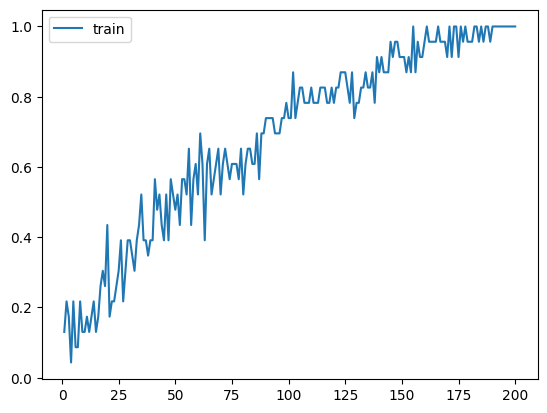

In [22]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

In [23]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [25]:
message = "Hola buenos dias"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Hola! ¿En qué puedo ayudarte hoy?


In [26]:
message = "¿Qué especialidades tienen?"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Tenemos médicos especializados en varias áreas, ¿en qué puedo orientarte?


In [27]:
message = "Psicologia"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Tenemos médicos especializados en varias áreas, ¿en qué puedo orientarte?


In [29]:
message = "Traumatologia"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Hay medicos disponibles para ello


In [30]:
message = "Me gustaria una cita"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Para agendar una cita, puedes llamarnos al <número de teléfono> o acceder a nuestro sitio web para citas en línea.


In [31]:
message = "Perfecto y cuanto me costaria?"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Los costos de las consultas médicas pueden variar según la especialidad. Para obtener información detallada, por favor, llámanos al <número de teléfono>.


In [32]:
message = "Perfecto, hasta luego"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset_medico)
print(result)

BOT: Hablamos luego. ¡Que tengas un buen día!


In [ ]:
|